# Buckling Analysis of Euler's Column

***

This notebook shows the calculation of the buckling load of Euler's column, that is to say a pin-ended column loaded in compression. Four methods are considered: Euler's analytical formula, MSC Nastran SOL 105's linear buckling analysis, MSC Nastran SOL 106's nonlinear buckling method and monitoring the definiteness of the tangent stiffness matrix during a nonlinear static analysis (using MSC Nastran SOL 106). The notebook is freely inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539) on the buckling analysis of a column with MSC Nastran.
* [Euler's buckling load](#euler)
* [Setup of the numerical model](#numerical-model)
* [SOL 105 - linear buckling analysis](#linear-buckling)
* [SOL 106 - nonlinear buckling method](#nonlinear-buckling)
* [SOL 106 - tangent stiffness matrix](#tangent-stiffness-matrix)
* [Conclusions](#conclusions)

## Euler's buckling load <a name="euler"></a>

***

Let's consider a column with diameter $d=20$ mm, length $l=420$ mm and Young's modulus $E=207$ GPa. The column is pinned at one end and has a roller support at the other end, where the load is applied in compression, as shown below.

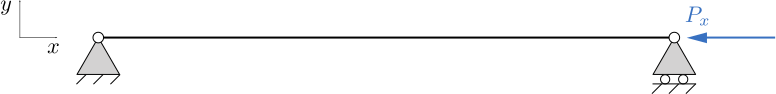

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '01_EulerColumn.svg'))  # sketch of Euler's column with boundary conditions and applied load


Euler's buckling load $P_{cr}$ is given by ([Megson 2016](https://books.google.co.uk/books?hl=it&lr=&id=l0u0DAAAQBAJ&oi=fnd&pg=PP1&ots=_ZMeCi8Xx5&sig=S8wxAUybKiR6e6f10uEOcdAPgjI&redir_esc=y#v=onepage&q&f=false)):
$$P_{cr}=\frac{\pi^2EI}{l^2},$$
where the area moment of inertia $I$ for a circular cross-sectional shape is calculated as:
$$I = \frac{\pi d^4}{64}.$$

Let's calculate $P_{cr}$ for our column.

In [2]:
import numpy as np  # package for matrix operations
d = 20.    # [mm]
l = 420.   # [mm]
E = 207e3  # [MPa]
I = np.pi*d**4/64  # [mm^4]
P_cr = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {P_cr:.0f} N')

Euler's buckling load: 90962 N


## Setup of the numerical model <a name="numerical-model"></a>

***

We want to run some linear and nonlinear analyses with MSC Nastran, so we need to create an appropriate numerical model and its corresponding input file. We'll use the [`pyNastran`](https://github.com/SteveDoyle2/pyNastran) package for this purpose.

We are going to define a base input object for our Nastran analyses. We'll complete this input object each time depending on the analysis we want to run. We'll use the function `create_base_bdf` from the `column_utils` module, where we can find some useful functions to work with Euler's column. `create_base_bdf` returns a `BDF` object representing a Nastran input file (.bdf) with nodes, beam elements, material properties, boundary conditions, unit compression force applied to the column and some parameters for the output format of the results. The function takes as input:
- material properties including Young's modulus, Poisson's ratio and density;
- geometric properties of the column, namely length and diameter;
- number of beam elements used to discretize the column.

Let's define the missing material properties and let's create a base bdf input with 420 beam elements, so that each element is 1 mm long.


In [3]:
from resources import column_utils  # module with functions for Euler's column

# Define missing parameters for create_base_bdf function
nu = 0.3  # Poisson's ratio
rho = 7.8e-4  # material density [tons/mm^3]
no_elements = 420  # number of beam elements used to discretize the column
# Create base bdf input
base_bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)

subcase=0 already exists...skipping


Now let's visualize a summary of our `BDF` object with the `get_bdf_stats` method.

In [4]:
print(base_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[4]: 1
  FORCE:   1

bdf.spcadds[3]: 1
  SPCADD:  1

bdf.spcs[1]: 1
  SPC1:    1

bdf.spcs[2]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 421

bdf.elements: 0
  CBEAM    : 420

bdf.properties: 0
  PBEAML   : 1

bdf.materials: 0
  MAT1     : 1




## SOL 105 - linear buckling analysis <a name="linear-buckling"></a>

***

The first numerical analysis that we are going to run with Nastran is a linear buckling analysis, using solution sequence SOL 105. To complete our bdf input for such analysis, we execute the following steps:
- create a deep copy of the base `BDF` object (in order to preserve the original base `BDF` object and reuse it later);
- assign SOL 105 as solution sequence;
- create first subcase where we apply the compression load;
- create second subcase where we solve the eigenvalue problem and consequently calculate the buckling load.

In [5]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

# Create a deep copy of base bdf object
linear_buckling_bdf = base_bdf_input.__deepcopy__({})
# Define solution sequence
linear_buckling_bdf.sol = 105
# Create first subcase for the application of a static load associated with the compression force
load_application_subcase_id = 1
force_set_id = list(linear_buckling_bdf.loads.keys())[0]
pynastran_utils.create_static_load_subcase(bdf_object=linear_buckling_bdf, subcase_id=load_application_subcase_id, load_set_id=force_set_id)
# Add EIGRL card to define a real eigenvalue analysis with the Lanczos method calculating only the first positive eigenvalue
eigrl_set_id = force_set_id+1
linear_buckling_bdf.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
# Create second subcase for the execution of the eigenvalue analysis
eigenvalue_calculation_subcase_id = 2
linear_buckling_bdf.create_subcases(eigenvalue_calculation_subcase_id)
linear_buckling_bdf.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_set_id)

The model for the linear buckling analysis is ready to run now! Let's define the name of the directory where we will run all the analyses of this notebook and the name of our input bdf file. We then call the `run_analysis` function from the `pynastran_utils` module, which we imported earlier. This module contains many useful functions to work with `pyNastran` objects. The function `run_analysis` creates the analysis directory if it doesn't exist alreardy, writes the input `BDF` object to a bdf file and runs the analysis with Nastran.

In [6]:
# Define name of analysis directory
analysis_directory_name = '01_Buckling_Analysis_of_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Define input name
base_input_name = 'euler_column'
linear_buckling_input_name = base_input_name + '_linear_buckling'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=linear_buckling_bdf, bdf_filename=linear_buckling_input_name)

Now we can read Nastran's op2 output file with the `read_op2` function and we can look at the eigenvalue calculated in the second subcase. Since the eigenvalue represents the ratio between the buckling and the applied load, and since our applied load was 1 N, the eigenvalue corresponds to the buckling load. Let's print its value and the percentage difference with respect to the analytical result.

In [7]:
from pyNastran.op2.op2 import read_op2  # function to read the Nastran's op2 file

# Read op2 file
op2_filename = os.path.join(analysis_directory_path, linear_buckling_input_name + '.op2')
linear_buckling_op2 = read_op2(op2_filename, debug=False)
# Find eigenvalue
sol_105_buckling_load = linear_buckling_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
# Print results
print(f'SOL 105 buckling load: {sol_105_buckling_load:.0f} N')
print(f'Difference with respect to analytical buckling load: {(sol_105_buckling_load/P_cr-1)*100:.2f} %')

SOL 105 buckling load: 90578 N
Difference with respect to analytical buckling load: -0.42 %


We observe only a negligible difference with respect to Euler's buckling load, which can be most probably ascribed to the discretization error.

Let's visualize the buckling shape using the `plot_buckling_shape` function from the `column_utils` module.

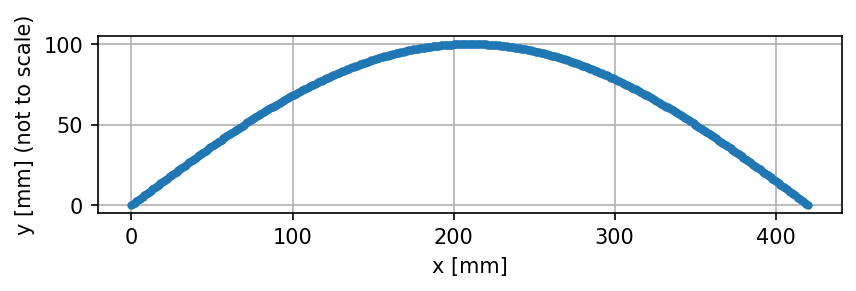

In [8]:
import matplotlib.pyplot as plt   # plotting package

plt.rcParams['figure.dpi'] = 150  # set default dpi of figures
column_utils.plot_buckling_shape(bdf_object=linear_buckling_bdf, op2_object=linear_buckling_op2)

## SOL 106 - nonlinear buckling method <a name="nonlinear-buckling"></a>

***

Our next numerical analysis is a nonlinear analysis with solution sequence SOL 106, where we want to use the so-called nonlinear buckling method. This method was described by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016) and is based on the hypothesis that the components of the tangent stiffness matrix vary linearly in a small range close to the last two converged solutions. If a critical point exists sufficiently close to the last converged solution, then the singularity of the tangent stiffness matrix at the critical point allows to formulate the following eigenvalue problem:

$$[K_n+\lambda\Delta K]\{\phi\}=\{0\},$$

where $[\Delta K]=[K_n-K_{n-1}]$ is the differential stiffness matrix based on the last two converged solutions $n$ and $n-1$. $\lambda$ and $\{\phi\}$ are respectively the eigenvalues and the eigenvectors related to the critical displacements $\{U_{cr}\}$:

$$\{U_{cr}\}=\{U_n\}+\lambda\{\Delta U\},$$

with $\{\Delta U\}=\{U_n\}-\{U_{n-1}\}$. Nastran calculates the critical buckling load $\{P_{cr}\}$ as:

$$\{P_{cr}\}=\{P_n\}+\alpha\{\Delta P\},$$

where $\{P_n\}$ is the applied load, $\alpha$ is the critical buckling factor and $\{\Delta P\}$ is the last load increment applied in the nonlinear analysis. $\alpha$ and $\lambda$ are related by the following expression:

$$\alpha=\frac{\lambda\{\Delta U\}^\intercal[K_n+\frac{1}{2}\lambda\Delta K]\{\Delta U\}}{\{\Delta U\}^\intercal\{\Delta P\}}.$$

To complete our bdf input for this analysis, we execute the following steps:
- create a deep copy of the base `BDF` object;
- assign SOL 106 as solution sequence;
- create first subcase where we apply a compression force equal to SOL 105's critical buckling load;
- define the parameters for the eigenvalue computation, this time carried out in the same subcase.

In [9]:
# Create deep copy of BDF object
nonlinear_buckling_bdf = base_bdf_input.__deepcopy__({})
# Define solution sequence
nonlinear_buckling_bdf.sol = 106
# Set force magnitude equal to SOL 105 buckling load and create first subcase
nonlinear_buckling_bdf.loads[force_set_id][0].mag = sol_105_buckling_load
first_subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_buckling_bdf, subcase_id=first_subcase_id, load_set_id=force_set_id)
# Define data needed to perform eigenvalue analysis with inverse power method
eigb_set_id = force_set_id+1
nonlinear_buckling_bdf.add_eigb(sid=eigb_set_id, method='INV', L1=-1e-10, L2=1e10, nep=1, ndp='', ndn='', norm='', G='', C='',)
nonlinear_buckling_bdf.case_control_deck.subcases[first_subcase_id].add_integer_type('METHOD', eigb_set_id)

In SOL 106 we need to specify some additional parameters and cards for the nonlinear analysis.

First we define two PARAM cards to enable large displacement effects and to flag the use of the nonlinear buckling method.

In [11]:
nonlinear_buckling_bdf.add_param('LGDISP', [1])  # assume all nonlinear structural element types that have a large displacement capability to have large displacement effects
nonlinear_buckling_bdf.add_param('BUCKLE', [2])  # request the nonlinear buckling analysis

PARAM     BUCKLE       2


Successively we define the arc-length method as our iteration method. We first add the NLPARM card to set the general parameters of the nonlinear iteration strategy. We use the following settings:
* `ninc=100` to set the initial load increment ($1/NINC$);
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration;
* `max_iter=25` to set the maximum number of iterations for each load increment;
* `conv='PUV'` to select convergence criteria based on load equilibrium and displacement error with vector component checking (convergence checking is performed on the maximum vector component of all components in the model);
* `int_out='YES'` to process the output for every computed load increment;
* `eps_p=1e-3` and `eps_u=1e-3` to set the error tolerance for the load and displacement criteria, respectively;
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment.

Then we add a NLPCI card to define the parameters of the arc-length method:
* `Type='CRIS'` to set Crisfield constraint type;
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, where $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$;
* `desiter=5` to set the desired number of iterations for convergence, which is used to calculate the arc-length for the next increment $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$, where $I_{max}$ represents the number of iterations required for convergence in the previous load increment;
* `mxinc=1000` to set the maximum number of controlled increment steps allowed within a subcase.

The parameters employed here are inspired by the [Shallow Cylindrical Shell Snap-through example](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38.xhtml#TOC_Shallow_Cylindrical) from the MSC Nastran *Demontration Problems Guide - Implicit Nonlinear*.

In [10]:
nlparm_id = 1
nonlinear_buckling_bdf.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
nonlinear_buckling_bdf.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=1000)
nonlinear_buckling_bdf.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

Now our input is ready to be run, so let's define a name for our input bdf file and call the `run_analysis` function.

In [12]:
nonlinear_buckling_input_name = base_input_name + '_nonlinear_buckling_method'  # input file name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, bdf_filename=nonlinear_buckling_input_name)  # run analysis

We read the nonlinear buckling load $P_{cr}$ and the critical buckling factor $\alpha$ using the `read_nonlinear_buckling_load_from_f06` function from the `pynastran_utils` module. We print the results and plot the buckling shape.

SOL 106 buckling load: 90578 N
Critical buckling factor ALPHA = -4.3e-06


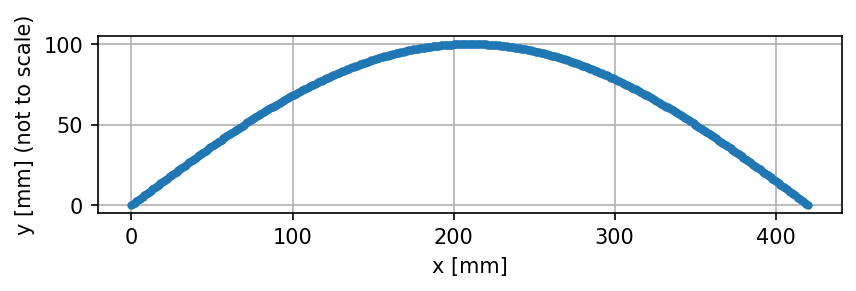

In [13]:
f06_filepath = os.path.join(analysis_directory_path, nonlinear_buckling_input_name + '.f06')  # path to .f06 file
op2_filepath = os.path.join(analysis_directory_path, nonlinear_buckling_input_name + '.op2')  # path to .op2 file
nonlinear_buckling_op2 = read_op2(op2_filename=op2_filepath, debug=False)  # return OP2 object by reading the .op2 file
sol_106_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=f06_filepath, op2_object=nonlinear_buckling_op2)  # return list of nonlinear buckling loads and list of critical buckling factors
print(f'SOL 106 buckling load: {sol_106_buckling_loads[0]:.0f} N\nCritical buckling factor ALPHA = {critical_buckling_factors[0]:.1e}')  # print results
column_utils.plot_buckling_shape(bdf_object=nonlinear_buckling_bdf, op2_object=nonlinear_buckling_op2)  # plot buckling shape

We observe that there is no noticeable difference between the linear and the nonlinear buckling load and shape. In fact, given the symmetry of the problem and the absence of material nonlinearities, there is no reason why the buckling load and shape should differ between the two analyses. Furthermore, the absolute value of $\alpha$ is well below unity, which suggests that the points used to calculate the differential stiffness matrix are close to the critical point (see [Lee & Herting, 1985](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016)).

## SOL 106 - tangent stiffness matrix <a name="tangent-stiffness-matrix"></a>

***

The stability of an equilibrium point of a structure is assessed by looking at the Hessian of the potential energy, that corresponds to the tangent stiffness matrix at that point. The tangent stiffness matrix is positive definite for stable points, while at critical points the matrix becomes singular. This means that at least one eigenvalue must be zero. As a consequence, we can assess the buckling load of Euler's column by looking at the load where the lowest eigenvalue of the tangent stiffness matrix becomes null.

For this analysis we use the same input used for the nonlinear buckling method. We only need to add a command to calculate the lowest eigenvalue of the tangent stiffness matrix at every load increment and print it in the f06 file. For this purpose, we include an appropriate DMAP sequence in the executive control statements.

In [14]:
nonlinear_buckling_bdf.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv_nobuckle.dmap') + '\'']  # include DMAP sequence

It should be noted that in theory we would not need to use PARAM,BUCKLE,2 for this analysis, as we are not looking for the critical buckling factor, like we did in the previous analysis. However, without such line Nastran does not update the tangent stiffness matrix after the last load increment and as a consequence we would be looking at the tangent stiffness matrix after the second to last load increment. For this reason we keep the parameter PARAM,BUCKLE,2 making sure that the DMAP sequence skips the buckling calculation.

Let's apply a compression load equal to the buckling load found in the previous analyis with SOL 106 rounded up to the next thousand, in order to observe the lowest eigenvalue of the tangent stiffness matrix becoming negative, and let's run the analysis.

In [15]:
# Change magnitude of applied compression force
force_magnitude = np.ceil(sol_106_buckling_loads[0]/1e3)*1e3
nonlinear_buckling_bdf.loads[force_set_id][0].mag = force_magnitude
# Define name of input file
tangent_stiffness_matrix_input_name = base_input_name + '_tangent_stiffness_matrix'  # name of current analysis
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, bdf_filename=tangent_stiffness_matrix_input_name)

Now we want to plot the lowest eigenvalue of the tangent stiffness matrix for every load increment versus the load history of the nonlinear analysis. We first find the load history of the nonlinear analysis using the function `read_load_displacement_history_from_op2` from the `pynastran_utils` module. Successively, we find the lowest eigenvalues in the f06 file using the function `read_kllrh_lowest_eigenvalues_from_f06` from the `pynastran_utils` module. Finally, we plot the results and print the lowest eigenvalue of the tangent stiffness matrix at the last converged solution.

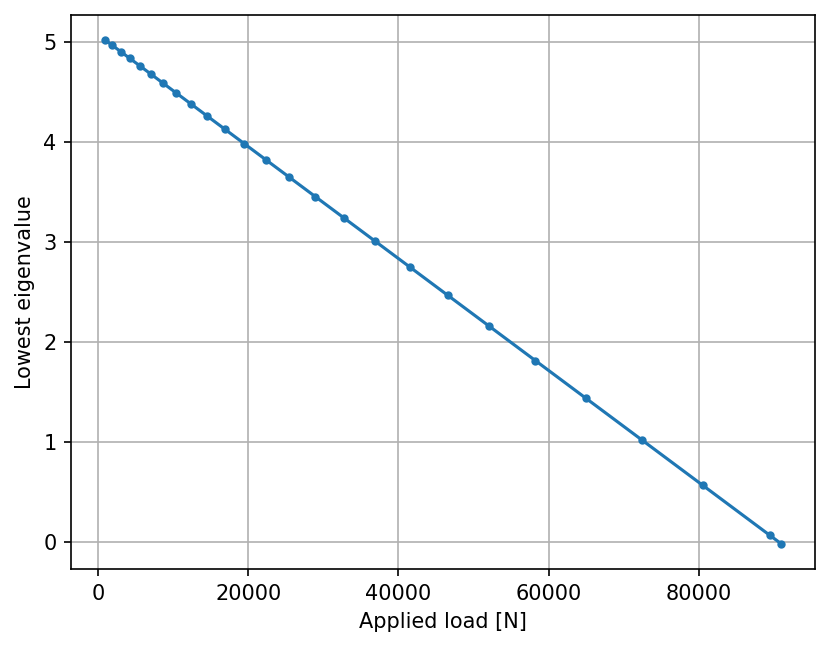

Value of lowest eigenvalue after final load increment: -0.024


In [16]:
# Read OP2 file and find applied load history
op2_filepath = os.path.join(analysis_directory_path, tangent_stiffness_matrix_input_name + '.op2')
tangent_stiffness_matrix_op2 = read_op2(op2_filename=op2_filepath, debug=False)
_, load_history, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=tangent_stiffness_matrix_op2)
applied_load_history = -[*load_history.values()][0][:,0]
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, tangent_stiffness_matrix_input_name + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
fig, ax = plt.subplots()
ax.plot(applied_load_history, lowest_eigenvalues, '.-')
plt.xlabel('Applied load [N]')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()
# Print last value of lowest eigenvalue
print(f'Value of lowest eigenvalue after final load increment: {lowest_eigenvalues[-1]:.3f}')

We can now interpolate between the last two lowest eigenvalues to find the critical buckling load, that is the load where the lowest eigenvalue is zero.

In [17]:
# Fit line between last two points
fit = np.polyfit(lowest_eigenvalues[-2:], applied_load_history[-2:], 1)
line = np.poly1d(fit)
# Find load where eigenvalue is zero
tangent_stiffness_matrix_buckling_load = line(0.)
# Print results
print(f'Load where tangent stiffness matrix becomes singular: {tangent_stiffness_matrix_buckling_load:.0f} N')

Load where tangent stiffness matrix becomes singular: 90578 N


We observe that there is no evident difference with the other numerical results.

## Conclusions <a name="conclusions"></a>

***

We analyzed the buckling load of the Euler's column with different methods. First we used Euler's analytical formula, and for the considered geometry and material we obtained a buckling load of 90962 N. Successively we used MSC Nastran to compute the buckling load of the column with different types of numerical analysis.

We discretized the column with beam elements and we carried out a linear buckling analysis with SOL 105. This resulted in a buckling load of 90578 N, that is 0.42% lower than the analytical result. Then we switched to Nastran's nonlinear solution sequence, SOL 106. We first used the nonlinear buckling method available with the solution sequence, resulting in the same buckling load obtained with SOL 105. Then we used SOL 106 to find the load where the lowest eigenvalue of the tangent stiffness matrix becomes null, that is to say where the matrix becomes singular. The same value of buckling load found was obtained also in this case. As a consequence, the different buckling calculations carried out with Nastran appear to be consistent. This is in line with expectations because no nonlinear behavior is supposed to be observed up to the buckling point considering the symmetry of the problem.

We will continue our investigation on the Euler's column studying its supercritical pitchfork bifurcation in our [next notebook](02_Supercritical_Pitchfork_Bifurcation_Euler_Column.ipynb).

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [18]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()